# Data Cleaning & EDA (Refactored)

- 输入：`data/heart.csv`
- 任务：缺失/异常处理、类型转换、EDA 概览、导出 `heart_data_cleaned.csv`
- 不包含：建模、部署（请在其他 notebook 完成）



In [10]:
import pandas as pd
import numpy as np

RAW_PATH = "data/heart.csv"
CLEAN_PATH = "heart_data_cleaned.csv"

# 读取数据
heart = pd.read_csv(RAW_PATH)
print("Raw shape:", heart.shape)

# 将 0 视为缺失的列（根据业务规则）
zero_to_na_cols = ["Cholesterol", "RestingBP"]
heart[zero_to_na_cols] = heart[zero_to_na_cols].replace(0, np.nan)

# 简单异常值处理：胆固醇 <50 或 >600 视为缺失，再用中位数填补
chol = heart["Cholesterol"]
mask_chol = (chol < 50) | (chol > 600)
heart.loc[mask_chol, "Cholesterol"] = np.nan

# 中位数填补缺失
for c in ["Cholesterol", "RestingBP"]:
    median_val = heart[c].median()
    heart[c] = heart[c].fillna(median_val)
    print(f"Imputed {c} with median={median_val}")

# 类型转换：类别列转为 category
to_category = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]
# HeartDisease 显示与原版一致（No/Yes 顺序）
if "HeartDisease" in heart.columns:
    heart["HeartDisease"] = heart["HeartDisease"].map({0: "No", 1: "Yes", "0": "No", "1": "Yes"}).fillna(heart["HeartDisease"])

for c in to_category:
    heart[c] = heart[c].astype("category")

# 基本统计与分布概览
summary = heart.describe(include="all")
print(summary)

# 导出清洗结果
heart.to_csv(CLEAN_PATH, index=False)
print(f"Saved cleaned data -> {CLEAN_PATH}")

# 提示下一步
print("下一步：在 modelling_refactored.ipynb 中进行建模与评估。")



Raw shape: (918, 12)
Imputed Cholesterol with median=237.0
Imputed RestingBP with median=130.0
               Age  Sex ChestPainType   RestingBP  Cholesterol   FastingBS  \
count   918.000000  918           918  918.000000   918.000000  918.000000   
unique         NaN    2             4         NaN          NaN         NaN   
top            NaN    M           ASY         NaN          NaN         NaN   
freq           NaN  725           496         NaN          NaN         NaN   
mean     53.510893  NaN           NaN  132.538126   242.806100    0.233115   
std       9.432617  NaN           NaN   17.990127    52.061614    0.423046   
min      28.000000  NaN           NaN   80.000000    85.000000    0.000000   
25%      47.000000  NaN           NaN  120.000000   214.000000    0.000000   
50%      54.000000  NaN           NaN  130.000000   237.000000    0.000000   
75%      60.000000  NaN           NaN  140.000000   267.000000    0.000000   
max      77.000000  NaN           NaN  200.0000

## EDA：单变量与相关性概览

- 数值列：直方图、箱线图、相关系数矩阵
- 类别列：频数表/占比
- 仅用于快速诊断，不做建模（建模在 `modelling_refactored.ipynb`）



Numeric vars: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical vars: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
HeartDisease Distribution:
 HeartDisease
No     410
Yes    508
Name: count, dtype: int64
Proportion (%):
 HeartDisease
No     44.7
Yes    55.3
Name: count, dtype: float64


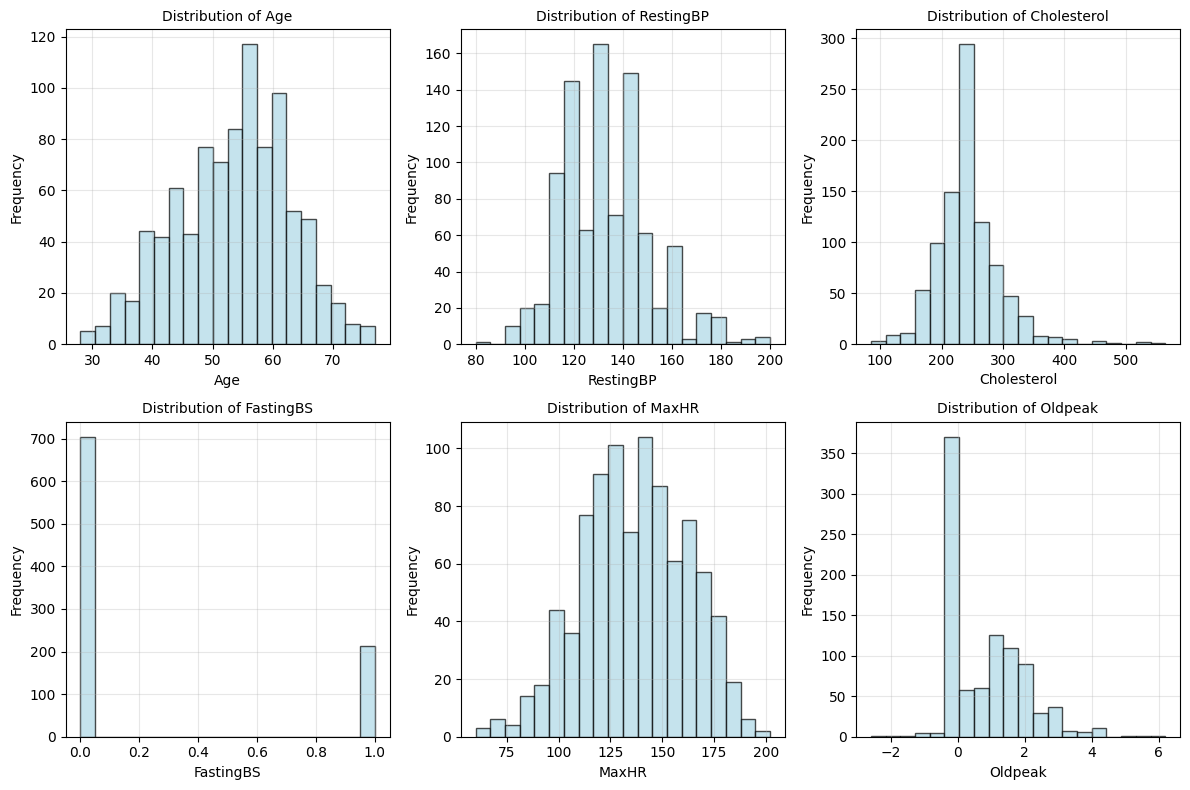

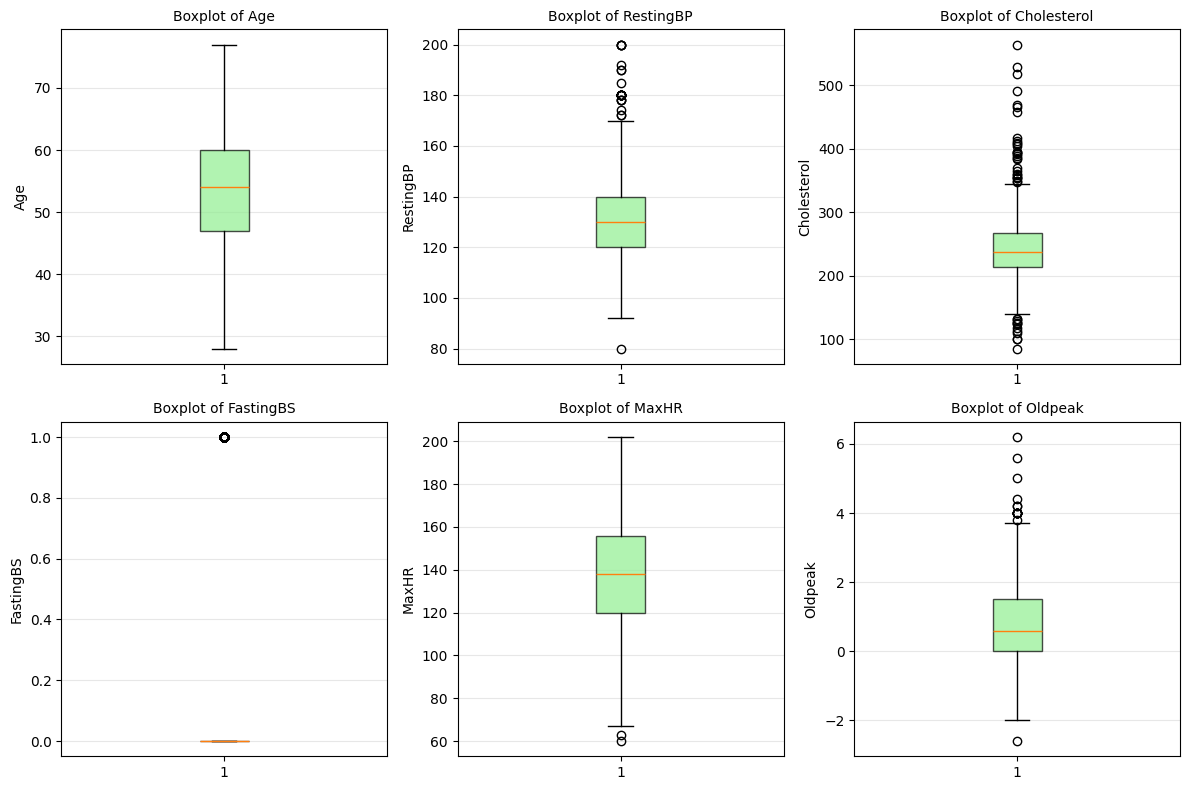

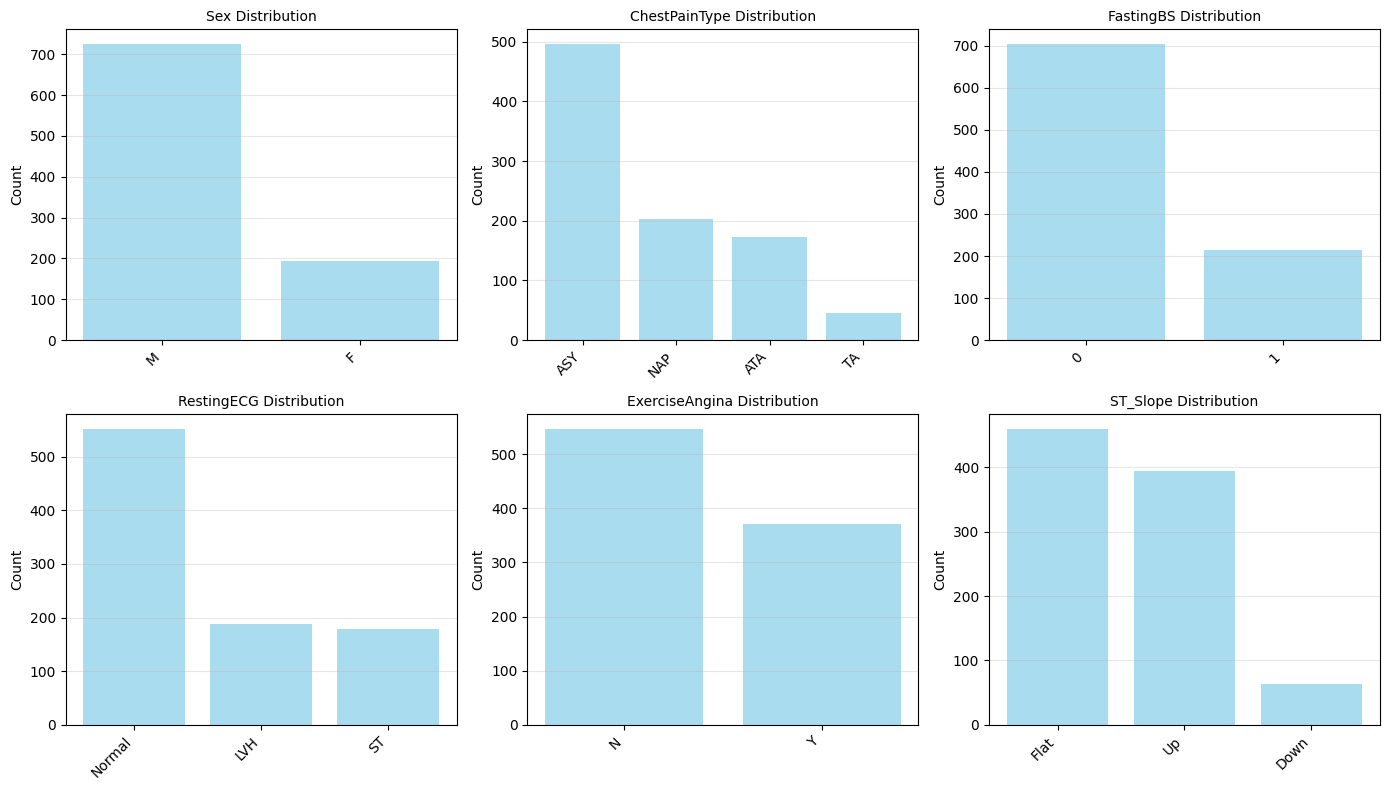


Correlation matrix (numeric):
                Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak
Age          1.000      0.263        0.046      0.198 -0.382    0.259
RestingBP    0.263      1.000        0.089      0.068 -0.110    0.174
Cholesterol  0.046      0.089        1.000      0.012  0.002    0.055
FastingBS    0.198      0.068        0.012      1.000 -0.131    0.053
MaxHR       -0.382     -0.110        0.002     -0.131  1.000   -0.161
Oldpeak      0.259      0.174        0.055      0.053 -0.161    1.000


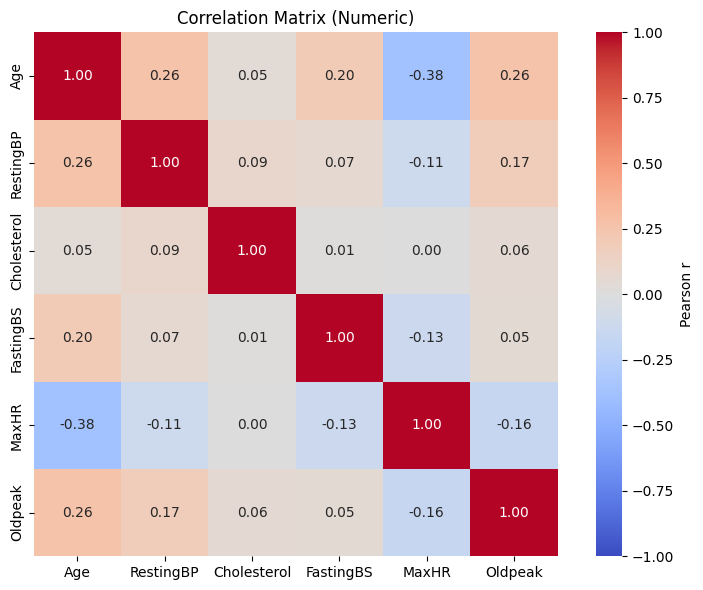

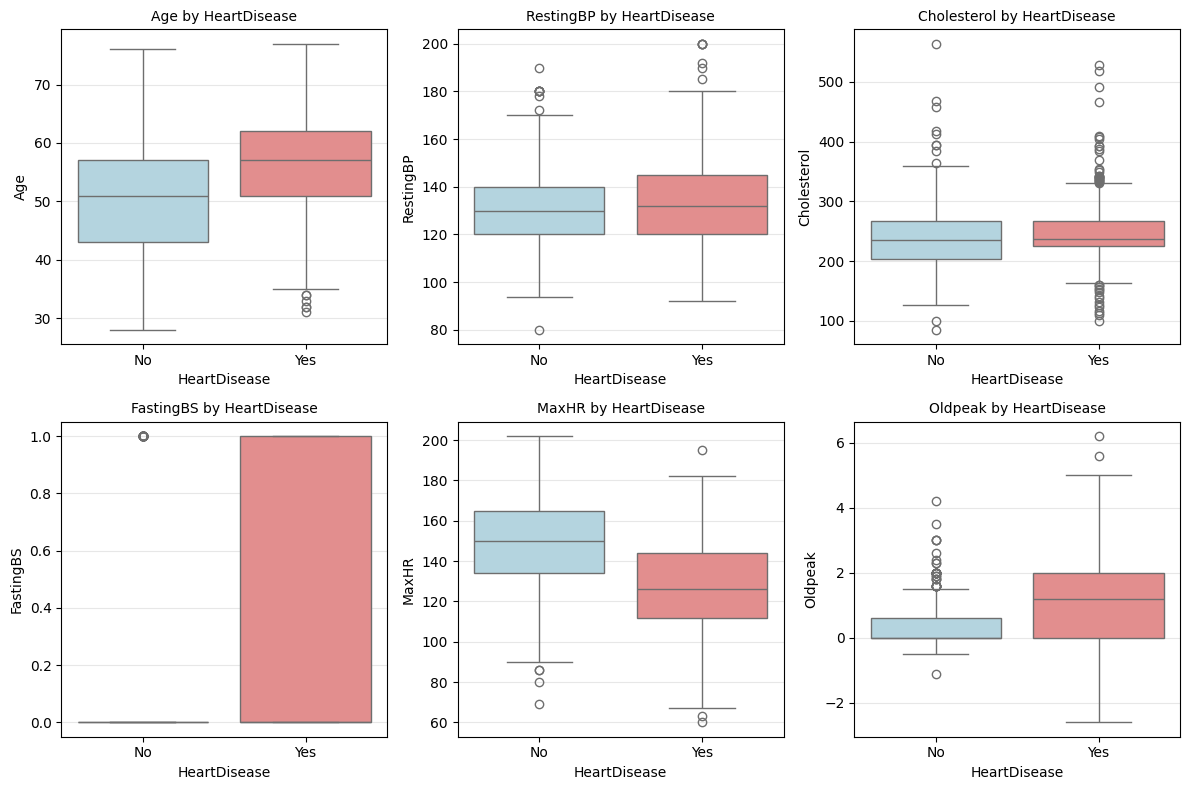


Sex vs HeartDisease:
HeartDisease   No  Yes
Sex                   
F             143   50
M             267  458
HeartDisease    No   Yes
Sex                     
F             74.1  25.9
M             36.8  63.2

ChestPainType vs HeartDisease:
HeartDisease    No  Yes
ChestPainType          
ASY            104  392
ATA            149   24
NAP            131   72
TA              26   20
HeartDisease     No   Yes
ChestPainType            
ASY            21.0  79.0
ATA            86.1  13.9
NAP            64.5  35.5
TA             56.5  43.5

FastingBS vs HeartDisease:
HeartDisease   No  Yes
FastingBS             
0             366  338
1              44  170
HeartDisease    No   Yes
FastingBS               
0             52.0  48.0
1             20.6  79.4

RestingECG vs HeartDisease:
HeartDisease   No  Yes
RestingECG            
LVH            82  106
Normal        267  285
ST             61  117
HeartDisease    No   Yes
RestingECG              
LVH           43.6  56.4
Normal        4

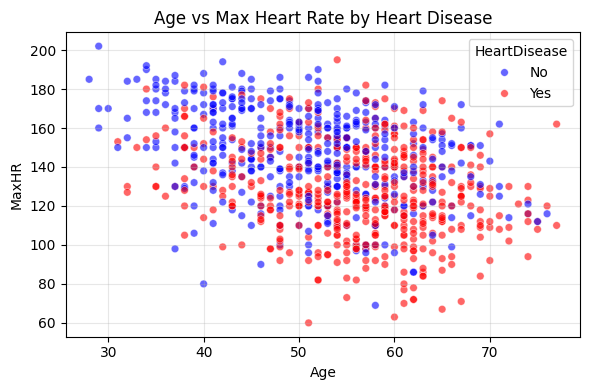

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_vars = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
categorical_vars = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

print("Numeric vars:", numeric_vars)
print("Categorical vars:", categorical_vars)

# HeartDisease 分布（保持 No/Yes 顺序）
hd_table = heart["HeartDisease"].value_counts().reindex(["No", "Yes"])
print("HeartDisease Distribution:\n", hd_table)
print("Proportion (%):\n", (hd_table / len(heart) * 100).round(1))

# 1) 数值直方图（3列）
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for ax, col in zip(axes, numeric_vars):
    ax.hist(heart[col], bins=20, color="lightblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Distribution of {col}", fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) 数值箱线图（逐列）
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for ax, col in zip(axes, numeric_vars):
    ax.boxplot(heart[col].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor="lightgreen", alpha=0.7))
    ax.set_title(f"Boxplot of {col}", fontsize=10)
    ax.set_ylabel(col)
    ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 3) 类别频数条形图（3列排列）
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
for ax, col in zip(axes, categorical_vars):
    vc = heart[col].value_counts()
    positions = np.arange(len(vc))
    ax.bar(positions, vc.values, color="skyblue", alpha=0.7)
    ax.set_title(f"{col} Distribution", fontsize=10)
    ax.set_xticks(positions)
    ax.set_xticklabels(vc.index.astype(str), rotation=45, ha="right")
    ax.set_ylabel("Count")
    ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 4) 相关系数矩阵（数值列）
corr = heart[numeric_vars].corr()
print("\nCorrelation matrix (numeric):\n", corr.round(3))
plt.figure(figsize=(8,6))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", square=True, cbar_kws={"label": "Pearson r"})
plt.title("Correlation Matrix (Numeric)")
plt.tight_layout()
plt.show()

# 5) 数值 vs HeartDisease 箱线图（与原版相同形态）
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for ax, col in zip(axes, numeric_vars):
    sns.boxplot(data=heart, x="HeartDisease", y=col, hue="HeartDisease",
                palette={"No": "lightblue", "Yes": "lightcoral"}, dodge=False, legend=False, ax=ax)
    ax.set_title(f"{col} by HeartDisease", fontsize=10)
    ax.set_xlabel("HeartDisease")
    ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 6) 类别 vs HeartDisease 列联表（打印占比，保持与原版一致）
for col in categorical_vars:
    ctab = pd.crosstab(heart[col], heart["HeartDisease"])
    print(f"\n{col} vs HeartDisease:\n{ctab}\n{(ctab.div(ctab.sum(axis=1), axis=0)*100).round(1)}")

# 7) 多变量散点：Age vs MaxHR，按 HeartDisease 着色
plt.figure(figsize=(6,4))
sns.scatterplot(data=heart, x="Age", y="MaxHR", hue="HeartDisease", palette={0:"blue", 1:"red", "No":"blue", "Yes":"red"}, alpha=0.6, s=30)
plt.title("Age vs Max Heart Rate by Heart Disease")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

